## Machine Learning Pipeline

We developed a complete Machine Learning pipeline with the goal of predicting the **fare_amount** variable from the regular dataset — green_tripdata_2015-01.parquet — previously used.

In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

### Reading the data

In [46]:
test = "green_tripdata_2015-01.parquet"

df = pd.read_parquet(test)

In [47]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                        int64
PULocationID                      int64
DOLocationID                      int64
passenger_count                   int64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                      int64
trip_type                       float64
congestion_surcharge             object
dtype: object

In [48]:
print(f"File has {len(df)} entries")
print(df.columns)
print()
print(df.head(20))

File has 1508493 entries
Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

    VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0          2  2015-01-01 00:31:10   2015-01-01 00:50:41                  N   
1          2  2015-01-01 00:01:05   2015-01-01 00:03:30                  N   
2          2  2015-01-01 00:09:01   2015-01-01 00:33:26                  N   
3          2  2015-01-01 00:17:34   2015-01-01 00:27:07                  N   
4          2  2015-01-01 00:32:38   2015-01-01 00:40:32                  N   
5          2  2015-01-01 00:45:30   2015-01-01 01:01:00                  N   
6          1  2015-01-01 00:54:04

### Preprocessing

In [49]:
# Add a column with the trip duration
df.insert(loc=0, column='duration', value=(df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds(), allow_duplicates=True)

In [50]:
# Removes all the columns that are not necessary
df.drop(columns=["VendorID","lpep_pickup_datetime", "lpep_dropoff_datetime", "store_and_fwd_flag", "RatecodeID", "PULocationID", "DOLocationID", "passenger_count", "extra", "mta_tax", "tip_amount", "tolls_amount", "ehail_fee", "improvement_surcharge", "total_amount", "payment_type", "trip_type", "congestion_surcharge"]) 

,duration,trip_distance,fare_amount
0,1171.0,5.88,20.0
1,145.0,0.89,4.5
2,1465.0,5.71,22.0
3,573.0,1.89,8.5
4,474.0,1.07,6.5
...,...,...,...
1508488,911.0,3.91,14.5
1508489,868.0,2.00,11.0
1508490,1583.0,4.70,20.5
1508491,672.0,5.98,18.0


In [51]:
# Remove invalid and null values
df = df[(df['duration'] > 0) & (df['trip_distance'] > 0) & (df['fare_amount'] > 0)]
df = df[['duration', 'trip_distance', 'fare_amount']].dropna()

print("Tamanho do DataFrame:", len(df))

Tamanho do DataFrame: 1479704


In [52]:
# Remove outliers
df = df[df['fare_amount'] < 200]

print("Tamanho do DataFrame:", len(df))

Tamanho do DataFrame: 1479604


### Training + Testing

### **XGBRegressor**

In [53]:
# Select the features and the target variable for regression
X_reg = df[['duration', 'trip_distance']]
y_reg = df['fare_amount']

In [54]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=28)

In [55]:
# Create a regression model using the XGBoost algorithm
xgb_model = XGBRegressor()

*K-Fold Cross Validation (k = 5)*

In [56]:
# Evaluate the regression model (XGBoost) using 5-fold cross-validation with the mean squared error (MSE)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

mse_cv = -cv_scores
rmse_cv = np.sqrt(mse_cv)

print("Cross-validation MSEs:", mse_cv)
print("Cross-validation RMSEs:", rmse_cv)
print("Média dos RMSEs:", np.mean(rmse_cv))

Cross-validation MSEs: [6.80235295 6.00272378 6.10380826 6.57376428 6.10241286]
Cross-validation RMSEs: [2.60813208 2.45004567 2.47058865 2.56393531 2.47030623]
Média dos RMSEs: 2.5126015871777563


In [57]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

*Hyperparameter tuning*

In [58]:
# Perform hyperparameter tuning of the XGBoost model using GridSearchCV with cross-validation (cv=3)
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7],
    'n_estimators': [50]  # We used only 50 to reduce the execution time.
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [59]:
y_pred = best_model.predict(X_test)

# Calculation of Regression Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Melhores parâmetros encontrados:", best_params)
print(f'MAE (Mean Absolute Error): {mae}')
print(f'MSE (Mean Squared Error): {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

Melhores parâmetros encontrados: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE (Mean Absolute Error): 0.5487087919183207
MSE (Mean Squared Error): 6.44641180760769
RMSE: 2.538978496877768
R^2: 0.9121837268180533


### Gráficos

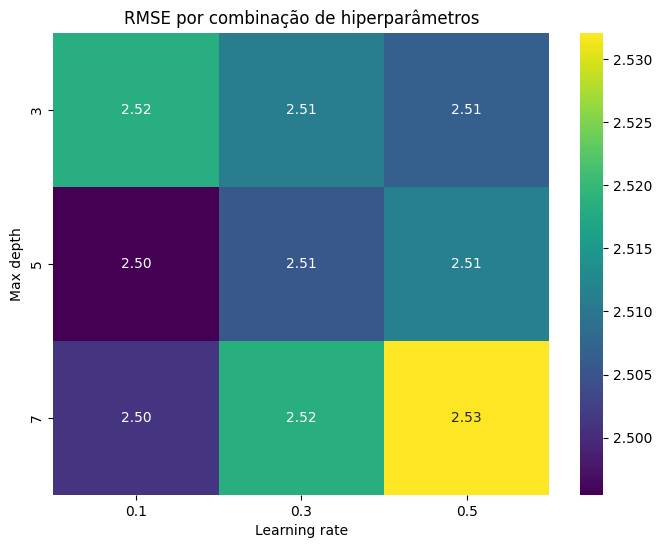

In [60]:
# Heatmap of RMSE values for each hyperparameter combination
results = pd.DataFrame(grid_search.cv_results_)
results['rmse'] = (-results['mean_test_score'])**0.5

pivot = results.pivot(index='param_max_depth', columns='param_learning_rate', values='rmse')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("RMSE por combinação de hiperparâmetros")
plt.xlabel("Learning rate")
plt.ylabel("Max depth")
plt.show()


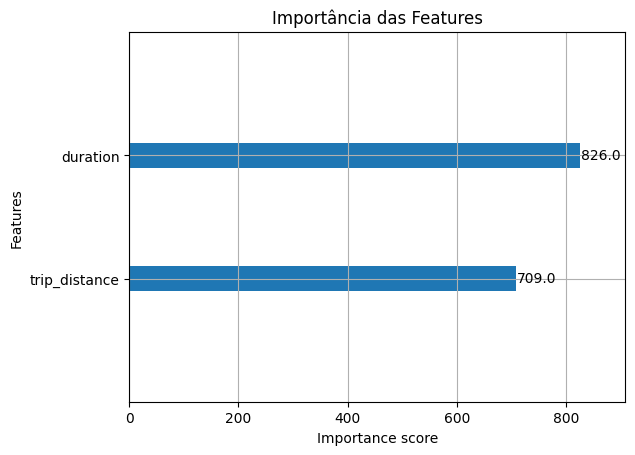

In [61]:
# Horizontal bar chart of Feature Importance
xgb.plot_importance(best_model)
plt.title("Importância das Features")
plt.show()

### **LogisticRegression**

In [62]:
# Create fare classes based on fare_amount
def categorizar_tarifa(fare):
    if fare <= 10:
        return 0  # barato
    elif fare <= 30:
        return 1  # médio
    else:
        return 2  # caro

df['fare_class'] = df['fare_amount'].apply(categorizar_tarifa)

In [63]:
# Selecionar as features e a variável target para a regressão
X_cls = df[['duration', 'trip_distance']]
y_cls = df['fare_class']

In [64]:
# Split into training and testing
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=28)

In [65]:
# Create a classification model
logreg_base = LogisticRegression(max_iter=1000)

*K-Fold Cross Validation (k=5)*

In [66]:
# Evaluate the performance of the classification model (LogisticRegression) using 5-fold cross-validation
cv_scores_cls = cross_val_score(logreg_base, X_train_cls, y_train_cls, cv=5, scoring='f1_macro')

print("Cross-validation F1-score (modelo base):", cv_scores_cls)
print("F1-score médio:", np.mean(cv_scores_cls))

Cross-validation F1-score (modelo base): [0.89014575 0.89163465 0.89010352 0.89430408 0.88948354]
F1-score médio: 0.8911343053638208


*Hyperparameter tuning*

In [67]:
# Perform hyperparameter tuning of the LogisticRegression model using GridSearchCV with cross-validation (cv=3)
# The features are pre-normalized using StandardScaler to ensure better performance and model convergence

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

grid_search_logreg = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid_logreg,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)

scaler = StandardScaler()
X_train_cls_scaled = scaler.fit_transform(X_train_cls)
X_test_cls_scaled = scaler.transform(X_test_cls)

grid_search_logreg.fit(X_train_cls_scaled, y_train_cls)
best_logreg = grid_search_logreg.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [68]:
y_pred_cls = best_logreg.predict(X_test_cls_scaled)

# Calculation of Classification Metrics
acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls, average='macro')
rec = recall_score(y_test_cls, y_pred_cls, average='macro')
f1 = f1_score(y_test_cls, y_pred_cls, average='macro')

print("Melhores parâmetros encontrados:", grid_search_logreg.best_params_)
print(f"Acuracy: {acc:.2f}")
print(f"Precison média: {prec:.2f}")
print(f"Recall médio: {rec:.2f}")
print(f"F1-score médio: {f1:.2f}")

Melhores parâmetros encontrados: {'C': 0.1, 'penalty': 'l2'}
Acuracy: 0.93
Precison média: 0.93
Recall médio: 0.86
F1-score médio: 0.89


### Gráficos

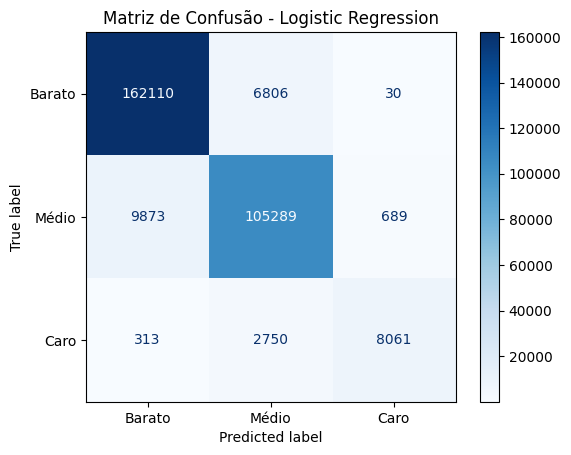

In [69]:
# Confusion Matrix Heatmap
ConfusionMatrixDisplay.from_estimator(
    best_logreg,
    X_test_cls_scaled,
    y_test_cls,
    display_labels=["Barato", "Médio", "Caro"],
    cmap='Blues'
)
plt.title("Matriz de Confusão - Logistic Regression")
plt.show()

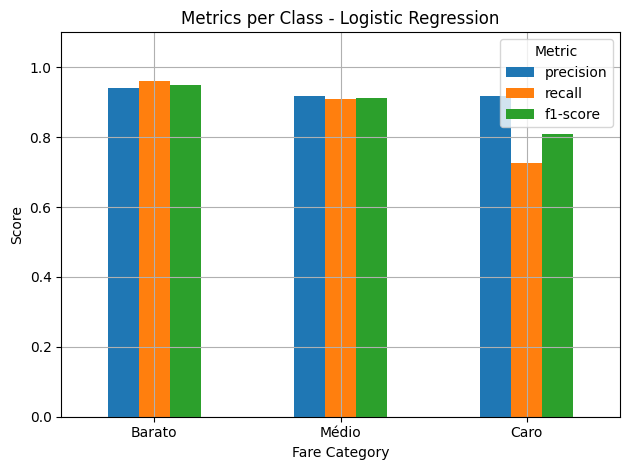

In [70]:
# Bar Chart of Metrics per Class

report = classification_report(y_test_cls, y_pred_cls, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:3]  # apenas as 3 classes

df_report[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("Metrics per Class - Logistic Regression")
plt.ylabel("Score")
plt.xlabel("Fare Category")  # eixo X com legenda
plt.xticks(ticks=range(3), labels=["Barato", "Médio", "Caro"], rotation=0)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()